In [1]:
import numpy as np
import networkx as nx
from PreFunctions import *
import matplotlib.pyplot as plt

In [2]:
##最小生成树定方向
def STreeDFS(T,node,DFlag,Direction):
	sorted_nei = sorted(T.neighbors(node),key=lambda x:abs(T.edges[x,node]['weight']),reverse=True)
	for nei in sorted_nei:
		if Direction[nei]!=0:
			continue
		Direction[nei]=int(Direction[node]*DFlag[nei,node])
		#print(Direction[node],Direction[nei])
		STreeDFS(T,nei,DFlag,Direction)
	return Direction

def TreeDFS(T,node,DFlag,Direction):
	for nei in T.neighbors(node):
		if Direction[nei]!=0:
			continue
		Direction[nei]=int(Direction[node]*DFlag[nei,node])
		#print(Direction[node],Direction[nei])
		TreeDFS(T,nei,DFlag,Direction)
	return Direction
	
def sigmoid(x):
	return 1/(1+np.exp(-x))

def DirectMST(direct_dict,reads):
	DG = nx.Graph()
	ReadsCount = len(reads)
	print(ReadsCount)
	ReadsDirection = [0 for i in range(ReadsCount)]
	DFlag = np.zeros((ReadsCount,ReadsCount))
	J_mat = np.zeros((ReadsCount,ReadsCount))
	for n1 in range(ReadsCount):
		for n2 in range(n1,ReadsCount):
			c1 = reads[n1]
			c2 = reads[n2]
			# if c1 in trouble_reads or c2 in trouble_reads:
			# 	continue
			key = str(min(c1,c2))+'-'+str(max(c1,c2))
			d_list = []
			if key in direct_dict:	
				d_list = direct_dict[key]
				# print(key,d_list)				
			if len(d_list)<1:
				continue
			d_sum = sum(d_list)
			d_abssum = sum(np.abs(d_list))
			posi = (d_sum+d_abssum)/2
			nega = (d_abssum-d_sum)/2
			J_mat[n1,n2] = d_sum #np.tanh(d_sum)#sigmoid(d_sum)#np.sign(d_sum)*np.sqrt(abs(d_sum))
			J_mat[n2,n1] = d_sum #np.tanh(d_sum)#sigmoid(d_sum)#np.sign(d_sum)*np.sqrt(abs(d_sum))#d_sum
			if max(posi,nega)>0:
				DG.add_edge(n1,n2,weight=-max(posi,nega)) #np.tanh
				DFlag[n1,n2] = np.sign(d_sum)
				DFlag[n2,n1] = DFlag[n1,n2]
				# print(c1,c2,DFlag[n1,n2],"weight",-max(posi,nega))
			else:
				print("Why?",key,d_list,d_sum,d_abssum,posi,nega)
	MST = nx.minimum_spanning_tree(DG)
	s_node = 0 #sorted(G.degree(),key = lambda x:x[1],reverse=True)[0][0]
	ReadsDirection[s_node]=1
	Direction = STreeDFS(MST,s_node,DFlag,ReadsDirection)
	return (Direction,J_mat)

In [3]:
# Alignments against reference genome, output from QUAST
from collections import defaultdict
quast_align = open('./all_alignments_SRR_HIFI_1w.tsv','r')
read_aligns = dict()
reads_aligncount =  defaultdict(int)
quast_direction = dict()
for line in quast_align:
    record = line.split('\t')
    if record[0].isdigit():
        read_name = record[5].split('.')[1]
        if int(record[2])<int(record[3]):
            start = record[0]
            end = record[1]
            quast_direction[read_name] = 1
        else:
            end = record[0]
            start = record[1]
            quast_direction[read_name] = -1
        read_aligns[int(read_name)] = start
        reads_aligncount[int(read_name)] +=1

In [4]:
def CalEstimateError(k, estimates_list, reads_list):
    Reads = reads_list[k]
    Estimates = estimates_list[k]
    print("Size",len(Reads))
    ## 选择一条read与基因组上的坐标对齐
    i = 0
    start_r = Reads[0]
    while reads_aligncount[start_r]!=1:
        i +=1
        start_r = Reads[i]
    start = int(read_aligns[start_r])

    Estimates_p = [x-Estimates[i]+start for x in Estimates]
    print("Here",start_r,read_aligns[start_r],Estimates_p[0])
    errors = []
    for r in range(len(Reads)):
        read_name = Reads[r]
        if reads_aligncount[read_name]==1:
            position = read_aligns[read_name]
            error = Estimates_p[r]-int(position)
            if error>4640000:
                error +=-4641652
            errors.append(error)        
            # print(Reads[r],Estimates_p[r],position,error)
        elif reads_aligncount[read_name]>1: #chimeric read
            continue
    return errors

In [5]:
from FindChimericRead import *

##去除可疑chimeric read后再进行试验
def FindChimeria(file_name,N):
    Read_olp_count,readLength = DCountOverlap(file_name)
    candidate_chimera = []
    for i in range(1,N+1):
        x = str(i)
        if x+'_F' in Read_olp_count and x+'_R' in Read_olp_count:
            LF = max(Read_olp_count[x+'_F'])+max(Read_olp_count[x+'_R'])
            # print(x,LF,readLength[x], LF>readLength[x])
            if LF<readLength[x]:
                candidate_chimera.append(x)
        else:
            candidate_chimera.append(x)
    return candidate_chimera
candidate_chimerias = FindChimeria('BLASR_selfmap_1w.Out',10000)
len(candidate_chimerias)

588

In [6]:
##去除chimeric read
ReadSeq,ReadInd = importLongReads('./SRR_HIFI_1w.fasta')
HangingOut = 80
G = nx.Graph()
edge_dict = {}
direct_dict = {}
trouble_reads= []
with open("./BLASR_selfmap_1w.Out",'r') as fin:
    for line in fin:
        record = line.strip().split()        
        (A_Orientation, B_Orientation, score)=list(map(int,record[2:5]))
        perSim = round(float(record[5]),2)
        (B_start, B_end, B_length, A_start, A_end, A_length) = list(map(int,record[6:12]))
        A_name,B_name = map(int,[record[0].split('.')[1],record[1].split('.')[1]])
        if A_name==B_name or str(A_name) in candidate_chimerias or str(B_name) in candidate_chimerias: #Add the overlap between each read and its reverse
            continue
        else:
            overlap={'A_name':A_name,'B_name':B_name,'A_Orientation':A_Orientation,'A_start':A_start,'A_end':A_end,'A_length':A_length,'B_Orientation':B_Orientation,'B_start':B_start,'B_end':B_end,'B_length':B_length,'perSim':perSim}
            key = str(min(A_name,B_name))+"-"+str(max(A_name,B_name)) ##direct_dict不需要分AB的顺序
            e_key = str(A_name)+"-"+str(B_name)
            hanging = max(min(A_start,B_start),min(A_length-A_end,B_length-B_end))
            # print("HangingOut",hanging)
            if A_Orientation==B_Orientation:
                ##权重绝对值越大可靠性越高
                direct = -score#perSim*(max((A_end-A_start)/A_length,(B_end-B_start)/B_length)) #以alignment fraction*perSim 作为权重
            else:
                direct = score#-perSim*(max((A_end-A_start)/A_length,(B_end-B_start)/B_length))
            if hanging<HangingOut: #min(A_start,B_start)<HangingOut and min(A_length-A_end,B_length-B_end)<HangingOut:
                if key in direct_dict:
                    # if direct in direct_dict[key]: ##repeat overlap
                    #     continue
                    direct_dict[key] += [direct]
                else:
                    direct_dict[key] = [direct]
                # if abs((A_end-A_start)-(B_end-B_start))>50:##比对长度相差太大
                #     continue                
                G.add_edge(A_name,B_name,weight = direct)
                if e_key in edge_dict:
                    edge_dict[e_key].append(overlap)
                else:
                    edge_dict[e_key]=[overlap]
fin.close()

In [7]:
Reads_List = []
Estimate_List = []
Outliers = []
Residual_list = []
Residual_2 =[]
sub_reads_list=[]
Direction_list = []
for subG in nx.connected_components(G):
    sub_reads = list(G.subgraph(subG).nodes())
    print("SubG.size",len(sub_reads))

    sub_reads_list.append(sub_reads)
    D,J_mat = DirectMST(direct_dict, sub_reads)
    
    Direction_list.append(D)
    if len(sub_reads)>9000:
        break
    # D = [quast_direction[str(r)] for r in sub_reads]
    # print(sub_reads,D)
    design, response = setupRegressionModel_direct(sub_reads,D)
    estimates_list, reads_list, outliers, residual_l, residual_2=IRLS_Huber(design, response, sub_reads,thr1=100,thr2=200)   

    Estimate_List.append(estimates_list)
    Reads_List.append(reads_list)
    Outliers.append(outliers)
    Residual_list.append(residual_l)
    Residual_2.append(residual_2)

SubG.size 9412
9412


In [8]:
design, response = setupRegressionModel_direct(sub_reads,D,edge_dict)
#estimates_list, reads_list, outliers, residual_l, residual_2=IRLS_Huber(design, response, sub_reads, thr1=200, thr2=500)   
estimates_list, reads_list, index_list, outliers, residual_l, residual_2=IRLS_Huber(design, response, sub_reads, thr1=300, thr2=600)   
# estimates_list, reads_list, index_list, outliers, residual_l, residual_2=IRLS_Huber(design, response, sub_reads, thr1=100, thr2=200)   

Inconsistent-direction overlap {'A_name': 592, 'B_name': 1017, 'A_Orientation': 0, 'A_start': 0, 'A_end': 3429, 'A_length': 14159, 'B_Orientation': 1, 'B_start': 10786, 'B_end': 14216, 'B_length': 14216, 'perSim': 99.91} -1 -1
Initial max_residual: 27858.69483 Regression Size: 33137
Quantile 50 55 60 ... 95,99: [3795.803623391378, 4244.704457086274, 4747.849623398513, 5287.2441616715305, 5905.066658336844, 6607.452084959816, 7485.187643396019, 8639.38847340799] 14787.573792639818
Quantile 50 55 60 ... 95,99: [2536.53074186085, 2981.321003954039, 3471.872765195494, 4024.4271288664854, 4707.614070319998, 5550.000060673861, 6669.53951028724, 8340.154093636835] 21140.1173563695
Quantile 50 55 60 ... 95,99: [1498.7175747648314, 1833.6315095662358, 2251.2081016143675, 2754.5781870637747, 3375.520533183444, 4233.153232637374, 5456.363496427129, 7423.606029583481] 28642.08485394858
Quantile 50 55 60 ... 95,99: [784.9893922819875, 1009.6651736936873, 1303.360284977811, 1683.3656823833687, 2184.

In [9]:
#layout的准确率
k_list = range(len(estimates_list))
Layout_Error = []
for k in k_list:
    Layout_Error.append(CalEstimateError(k,estimates_list,reads_list))

Layout_length = []
for k in range(len(k_list)):
    estimates_k = estimates_list[k]
    estimates_end = [estimates_k[i]+len(ReadSeq[str(reads_list[k][i])+'_F']) for i in range(len(estimates_k))]
    l_length = max(estimates_end)-min(estimates_k)
    # last_read = reads_list[k][np.argmax(estimates_list[k])]
    # last_read_length = len(ReadSeq[str(last_read)+'_F'])
    # l_length = max(estimates_list[k])-min(estimates_list[k])+last_read_length
    Layout_length.append(l_length)

Size 1153
Here 4933 987088 987088
Size 147
Here 6107 905208 905208
Size 2731
Here 4391 1841062 1841062
Size 1267
Here 832 237657 237657
Size 518
Here 1522 4076992 4076992
Size 650
Here 3659 1530301 1530301
Size 1209
Here 851 3126320 3126320
Size 748
Here 954 4390005 4390005
Size 118
Here 4508 3803244 3803244
Size 397
Here 7999 3874653 3874653
Size 200
Here 5485 125458 125458
Size 2
Here 4419 234021 234021
Size 2
Here 2534 2225355 2225355
Size 2
Here 2577 2708958 2708958
Size 2
Here 2620 4353060 4353060
Size 2
Here 2723 2095687 2095687
Size 2
Here 3223 224935 224935
Size 2
Here 3795 3535962 3535962
Size 2
Here 5863 2693254 2693254
Size 2
Here 4161 3858871 3858871
Size 2
Here 5285 1526994 1526994
Size 2
Here 6419 189917 189917
Size 2
Here 5647 1990954 1990954
Size 2
Here 9903 3021793 3021793
Size 2
Here 9176 884424 884424
Size 2
Here 6102 1970445 1970445
Size 2
Here 8164 3975667 3975667
Size 2
Here 7561 4348283 4348283
Size 2
Here 8607 3063512 3063512
Size 2
Here 9397 2920598 2920598


In [10]:
def CalReadDiff(overlap, D_i, D_j):
    diff = 0
    if overlap['B_Orientation']==1 and D_i!=D_j: #异向overlap
        print("D_i != D_j and overlap is reverse.")
        if D_i==1: #reads[i] --> reads[j] <--
            diff = overlap['A_end']+overlap['B_length']-overlap['B_end']
        elif D_i==-1: #reads[i] <-- reads[j] --> 
            diff = overlap['A_end']+overlap['B_length']-overlap['B_end']#overlap['B_length']-overlap['B_end']-overlap['A_length']+overlap['A_end']
            diff = -diff
        else:
            print("Error!")
    elif overlap['B_Orientation']==0 and D_i==D_j: #同向overlap                        
        if D_i==1: #reads[i] --> reads[j] -->    
            diff = overlap['A_start']-overlap['B_start']
        elif D_i==-1:#reads[i] <-- reads[j] <--
            diff = overlap['A_start']-overlap['B_start']#overlap['A_end']-overlap['A_length']+overlap['B_end']
            diff = -diff
        else:
            print("Error!")
    else:
        print('Two layouts are from different strains')
    return diff

def connectContigs(estimates_list, reads_list, index_list, X, D):
    Estimates_list=[]
    Reads_list=[]
    
    A = X.T.dot(X)
    G = nx.DiGraph()
    for i in range(len(reads_list)):
        G.add_node(i)
        for j in range(i+1,len(reads_list)):
            # print("Contig pair:", i,j)
            index1=index_list[i]
            estimate1=estimates_list[i]
            index2=index_list[j]
            estimate2=estimates_list[j]

            link=0
            overlap=[]
            for ind in range(len(estimate1))[-25:]:
                a=A[:,index1[ind]]
                for column in a.indices:
                    if column in index2[:25]:
                        link+=1
                        # print("Read A:", index1[ind], "Read B:", column, D[index1[ind]], D[column])
                        overlap.append((ind,index2.index(column)))
            if link>5:
                G.add_edge(i,j,overlap=overlap)
                
            link=0
            overlap=[]
            for ind in range(len(estimate1))[:25]:
                a=A[:,index1[ind]]
                for column in a.indices:
                    if column in index2[-25:]:
                        link+=1
                        # print("Read A:", index1[ind], "Read B:", column, D[index1[ind]], D[column])
                        overlap.append((index2.index(column),ind))
            if link>5:
                G.add_edge(j,i,overlap=overlap)
    # return G    
    while(len(G.nodes)>0):
        contig=list(G.nodes)[0]
        longestPath=[contig]
        EndEstimate = [estimates_list[contig][k]+len(ReadSeq[str(reads_list[contig][k])+'_F']) for k in range(len(estimates_list[contig]))]
        # leftEstimate=[estimates_list[contig][k]-len(reads_list[contig][k]['seq']) for k in range(len(estimates_list[contig]))]
        longestLen = max(EndEstimate)-min(estimates_list[contig])
        
        for root in G.nodes:
            for leaf in G.nodes:
                for path in nx.all_simple_paths(G, root, leaf):
                    Len=0
                    for contig in path:
                        EndEstimate = [estimates_list[contig][k]+len(ReadSeq[str(reads_list[contig][k])+'_F']) for k in range(len(estimates_list[contig]))]
                        # leftEstimate=[estimates_list[contig][k]-len(reads_list[contig][k]['seq']) for k in range(len(estimates_list[contig]))]
                        Len += max(EndEstimate)-min(estimates_list[contig])                        
                        if Len>longestLen:
                            longestLen=Len
                            longestPath=path

        Estimates_list.append([estimates_list[longestPath[0]]])
        Reads_list.append([reads_list[longestPath[0]]])
        print("longest path:", longestPath)
        
        for k in range(len(longestPath)-1):
            From=longestPath[k]
            To=longestPath[k+1]
            
            readsFrom=reads_list[From]  #pre contig
            estimatesFrom=estimates_list[From] 
            readsTo=reads_list[To]  #success contig
            estimatesTo=estimates_list[To]
            
            overlap=G[From][To]['overlap']
            for link in overlap:    #link=(read_a, read_b)
                key = str(readsFrom[link[0]])+'-'+str(readsTo[link[1]])
                # key_1 = str(readsTo[link[1]])+'-'+str(readsFrom[link[0]])
                if key in edge_dict:
                    translocation = CalReadDiff(edge_dict[key][0],D[index_list[From][link[0]]],D[index_list[To][link[1]]])
                    print("Translocation = ", translocation, estimatesFrom[link[0]])
                    translocation = translocation+estimatesFrom[link[0]]-estimatesTo[link[1]]
                    
                    estimates_list[To]=[k+translocation for k in estimatesTo]
                    Estimates_list[-1].append(estimates_list[To])
                    Reads_list[-1].append(readsTo)
                    break
                else:
                    continue
        for contig in longestPath:
            G.remove_node(contig)
    
    for k in range(len(Estimates_list)):
        Estimates_list[k]=[j for i in Estimates_list[k] for j in i]
        Reads_list[k]=[j for i in Reads_list[k] for j in i]
    
    return(Estimates_list, Reads_list)

longest path: [0, 5, 2, 6, 8, 9, 4, 7, 10, 3, 1]
D_i != D_j and overlap is reverse.
Translocation =  19108 261331
D_i != D_j and overlap is reverse.
Translocation =  -11696 589366
D_i != D_j and overlap is reverse.
Translocation =  -3827 1881917
Translocation =  13847 2533818
Translocation =  9062 2601430
Translocation =  -3246 2816063
D_i != D_j and overlap is reverse.
Translocation =  24043 3118680
D_i != D_j and overlap is reverse.
Translocation =  24164 3499124
D_i != D_j and overlap is reverse.
Translocation =  -2596 3622594
D_i != D_j and overlap is reverse.
Translocation =  -9344 4293321
longest path: [11]
longest path: [12]
longest path: [13]
longest path: [14]
longest path: [15]
longest path: [16]
longest path: [17]
longest path: [18]
longest path: [19]
longest path: [20]
longest path: [21]
longest path: [22]
longest path: [23]
longest path: [24]
longest path: [25]
longest path: [26]
longest path: [27]
longest path: [28]
longest path: [29]
4650572
Size 9138
Here 4933 987088 98

{'whiskers': [<matplotlib.lines.Line2D at 0x27cb4265630>,
 'caps': [<matplotlib.lines.Line2D at 0x27c854ed8a0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x27cb4264070>],
 'medians': [<matplotlib.lines.Line2D at 0x27c93dd9c90>],
 'fliers': [<matplotlib.lines.Line2D at 0x27c93ddaad0>],
 'means': []}

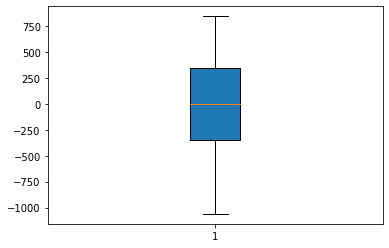

In [11]:
# thr1 = 300, thr2 = 600 
Estimates_list, Reads_list = connectContigs(estimates_list,reads_list,index_list, design,D)
print(max(Estimates_list[0])-min(Estimates_list[0]))
final_error = np.array(CalEstimateError(0,Estimates_list,Reads_list))
# max(abs(final_error-np.median(final_error)))
final_error = final_error-np.median(final_error)
plt.boxplot(final_error,patch_artist=True,)

In [21]:
np.std(final_error)

451.0364112855858

In [22]:
len(final_error)

9131

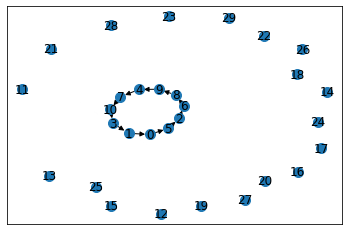

In [121]:
nx.draw_networkx(c_G,arrows=True,node_size=100)